In [11]:
from utils.cluster import group_kmeans, single_kmeans
from utils.visualize import (
    plot_distortions,
    plot_label_distr,
    plot_return,
    plot_return_box,
    plot_qq,
    report_return_mean_std,
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read and extract clustering attributes

In [16]:
# TODO: change arguments if necessary
# read path of training data
TRAIN_PATH = 'data/processed/spy_max_221118_train.csv'
# read path of testing data
TEST_PATH = 'data/processed/spy_max_221118_test.csv'
# timespan of 2 uses data from day i and day i-1
# timespan of 3 uses data from day i, day i-1, and day i-2
timespan = 3

In [17]:
# read data
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

# save clustering attributes to a new df
if timespan == 2:
    use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
                'volume/volume_i-1']
else:
    use_cols = ['open/open_i-1', 'high/high_i-1', 'low/low_i-1', 'close/close_i-1',
            'volume/volume_i-1', 'open_i-1/open_i-2', 'high_i-1/high_i-2', 'low_i-1/low_i-2',
            'close_i-1/close_i-2', 'volume_i-1/volume_i-2']
    
X = train[use_cols]
test_X = test[use_cols]

X.head()

,open/open_i-1,high/high_i-1,low/low_i-1,close/close_i-1,volume/volume_i-1,open_i-1/open_i-2,high_i-1/high_i-2,low_i-1/low_i-2,close_i-1/close_i-2,volume_i-1/volume_i-2
0,0.995400,0.998656,1.001282,1.001137,0.694338,1.004908,1.003834,1.002357,1.000142,1.288976
1,1.002768,1.008964,1.005330,1.008605,2.229417,0.999178,1.000149,1.000751,0.998954,0.483738
2,0.986817,0.987202,0.990846,0.980340,0.904607,0.987962,0.989567,0.974310,0.976321,1.763073
3,0.994090,0.998302,0.999909,1.005604,0.990637,0.988319,0.989918,0.993353,0.991931,1.182054
4,0.998198,0.992169,0.979762,0.973735,1.227363,0.999774,0.995323,0.999431,1.006124,1.322403


## Perform clustering and plot return distribution

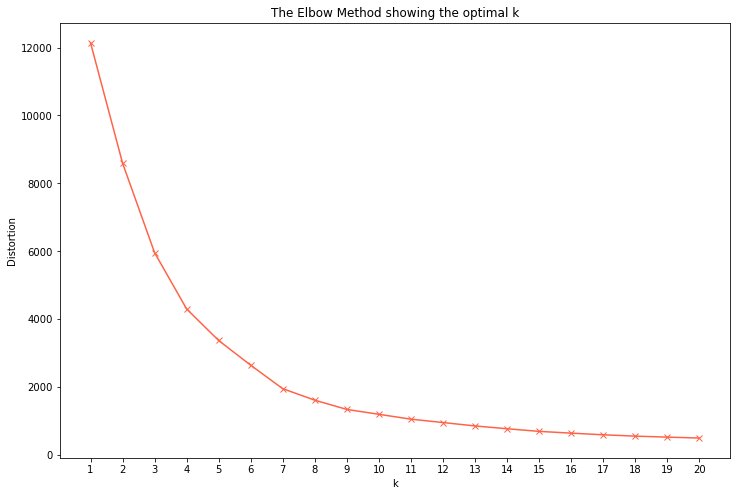

In [25]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_elbow_day_i_i-2_no_norm.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

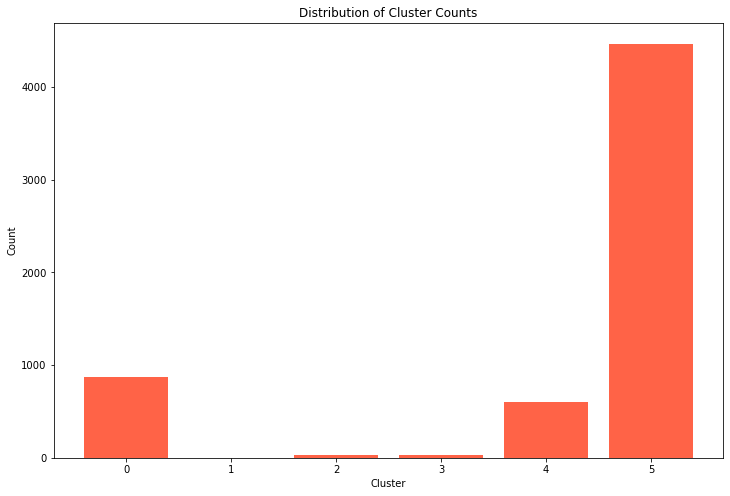

In [26]:
# perform kmeans with optimal k=4
opt_k = 6
model = single_kmeans(opt_k, X)
# plot distribution of labels
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_no_norm_cluster_distr.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are very imbalanced -> maybe need a way to improve later

## Perform clustering with standardized data and plot return
* variance of volume/volume_i-1 is much larger than the rest
* it could be a good idea to standardize data before clustering

In [20]:
print(X.var())
# standarsize 
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(X)

open/open_i-1            0.000139
high/high_i-1            0.000089
low/low_i-1              0.000128
close/close_i-1          0.000141
volume/volume_i-1        1.165050
open_i-1/open_i-2        0.000137
high_i-1/high_i-2        0.000087
low_i-1/low_i-2          0.000128
close_i-1/close_i-2      0.000141
volume_i-1/volume_i-2    0.857193
dtype: float64


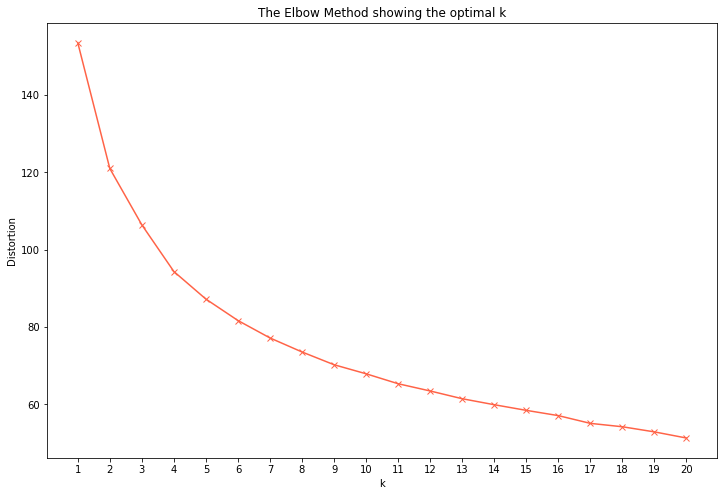

In [27]:
# perform kmeans
k_upper = 20
distortions = group_kmeans(k_upper, X_minmax)
# k=4 is the optimal k with elbow method
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_elbow.png'
plot_distortions(k_upper, distortions, fig_size, file_name)

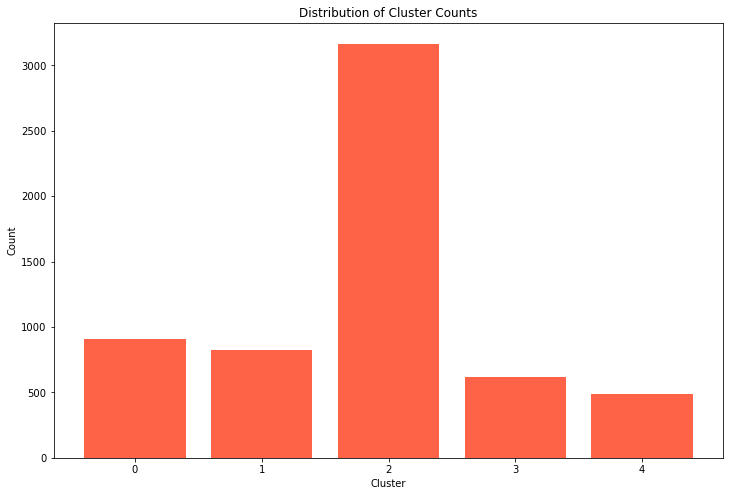

In [28]:
# perform kmeans with optimal k=4
opt_k = 5
model = single_kmeans(opt_k, X_minmax)
# plot distribution of labels
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_clusters.png'
plot_label_distr(model.labels_, fig_size, file_name)
# note:the clusters are still somehow imbalanced but much better

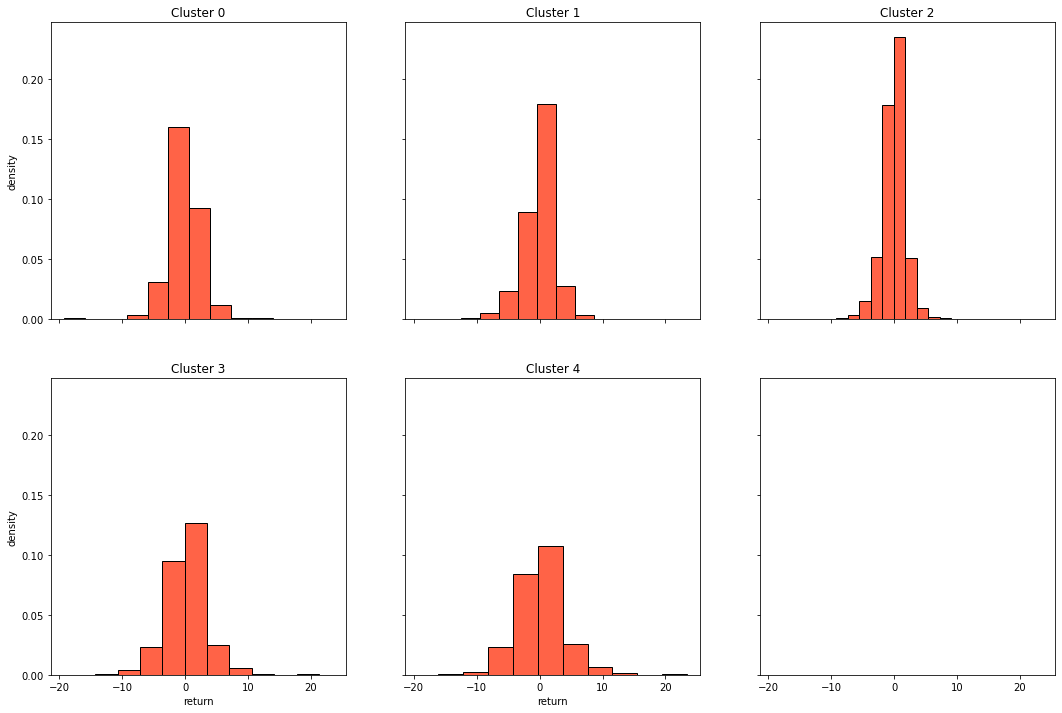

In [30]:
nrows, ncols = 2, 3
fig_size = (18, 12)
file_name = 'kmeans_day_i_i-2_returns.png'
plot_return(model.labels_, np.array(train['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)

## Results analysis on train and test data

In [31]:
# report mean and variance of each cluster return: training
report_return_mean_std(opt_k, model.labels_, np.array(train['return_i+1']))

cluster0 return: mean 0.007, std 2.5543
cluster1 return: mean -0.1237, std 2.5008
cluster2 return: mean -0.0275, std 1.7951
cluster3 return: mean 0.2672, std 3.2887
cluster4 return: mean 0.3135, std 4.033


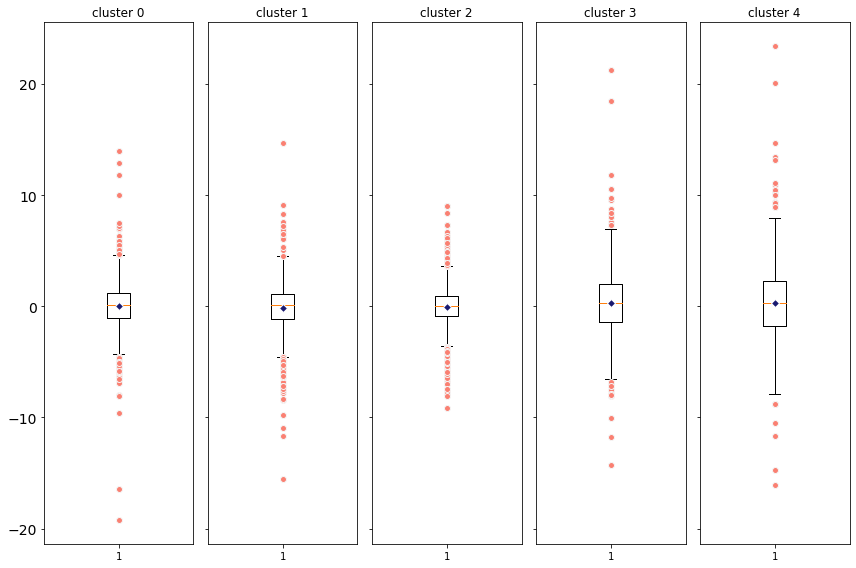

In [33]:
# box plot for training returns 
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_returns_boxplot.png'
plot_return_box(model.labels_, np.array(train['return_i+1']), opt_k, fig_size, file_name)

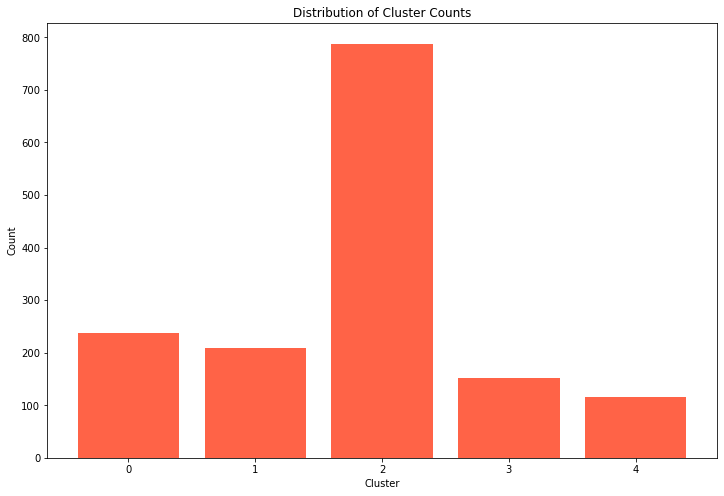

In [34]:
# predict cluster of test data and draw distribution
# standardize test_X
test_X_minmax = min_max_scaler.transform(test_X)
# predict clusters of test data
test_pred = model.predict(test_X_minmax)
# draw distribution
fig_size = (12, 8)
file_name = 'kmeans_day_i_i-2_clusters_test.png'
plot_label_distr(test_pred, fig_size, file_name)
# very similar distribution of clusters compared to train data
# test data distr mirrors train data distr based on clusters

E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
E:\softwares\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo"

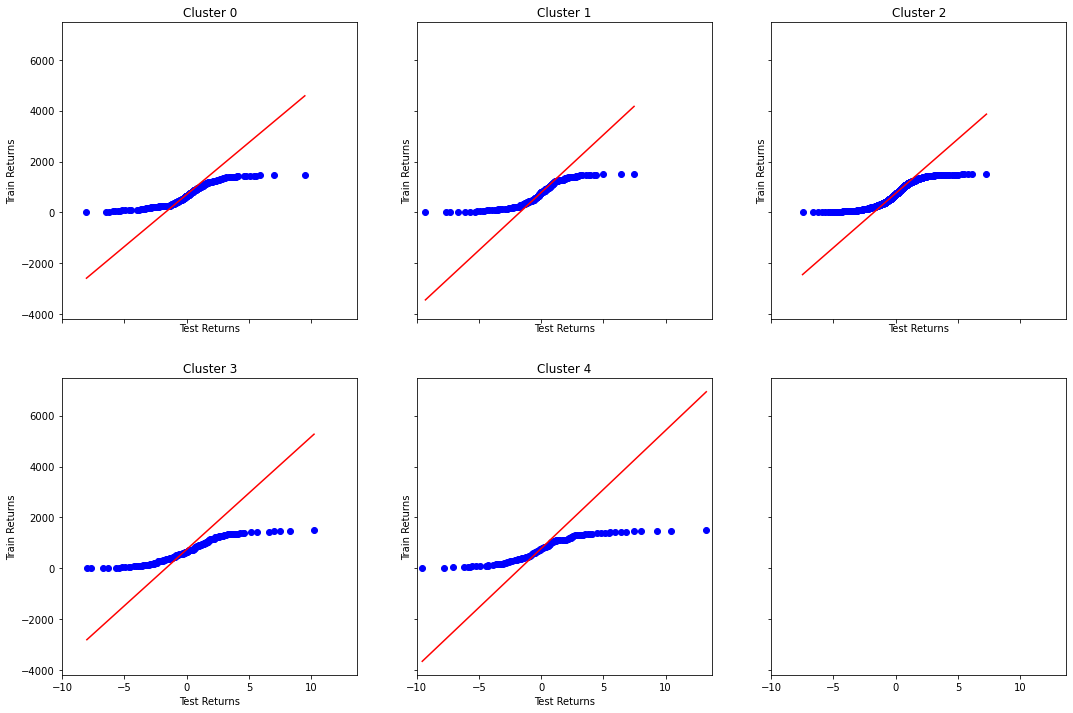

In [35]:
nrows, ncols = 2, 3
fig_size = (18, 12)
file_name = 'kmeans_day_i_i-1_qq.png'
plot_qq(model.labels_, test_pred, np.array(train['return_i+1']),
        np.array(test['return_i+1']), opt_k, nrows, ncols, fig_size, file_name)

In [36]:
# report mean and std of test returns for each cluster
report_return_mean_std(opt_k, test_pred, np.array(train['return_i+1']))

cluster0 return: mean -0.3878, std 2.8605
cluster1 return: mean -0.1302, std 2.2839
cluster2 return: mean 0.0454, std 2.2178
cluster3 return: mean 0.2226, std 2.4373
cluster4 return: mean 0.1717, std 2.5756
